# load data and do elementary calculations and plots

---

In [1]:
import os
import numpy as np
import dask
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

#import xscale

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.36:8786 Dashboard: http://10.148.1.36:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB


# Eta
_______


In [6]:
# read Eta outputs using xrray and xmitgcm
data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8218)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

In [ ]:
wt = ds.window
wt.set()

cutoff_10d = 10 # A 10-day cutoff

dx_1d = 1 # Define the sampling period (one day)

wt.set(n=20, dim='time', cutoff=cutoff_10d, dx=dx_1d, window='hanning')

res = wt.convolve()

res_valid = wt.convolve(trim=True)

In [ ]:
ds.isel(face=1, i=0, j=0, time=slice(0,1000)).plot(label="Raw data")
res.isel(face=1, i=0, j=0, time=slice(0,1000)).plot(label="Filtered data", ls="--")

plt.legend()
plt.show()

In [7]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   k (90) --> left
  * left     k_l (90) --> center
  * outer    k_p1 (91) --> center
  * right    k_u (90) --> center
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center

In [8]:
u_transport = ds.Eta * ds.dyG * ds.Eta * ds.drF
v_transport = ds.Eta * ds.dxG * ds.Eta * ds.drF

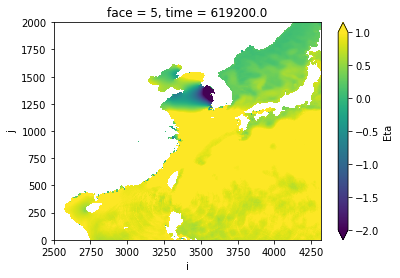

In [7]:
# plot Eta at face 5 and time 100
ds['Eta'].isel(face=5, time=100, i=slice(2500,4320), j=slice(0,2000)).plot(vmin=-2, vmax=1)

In [11]:
ds['Eta'].isel(face=1, i=0, j=0).mean().compute()

<xarray.DataArray 'Eta' ()>
array(-0.990892, dtype=float32)
Coordinates:
    i        int64 0
    j        int64 0
    face     int64 1
    XC       float32 -37.989582
    YC       float32 -57.001026
    rA       float32 1552802.6
    Depth    float32 3047.2024

CPU times: user 1.91 s, sys: 40 ms, total: 1.95 s
Wall time: 1min 7s


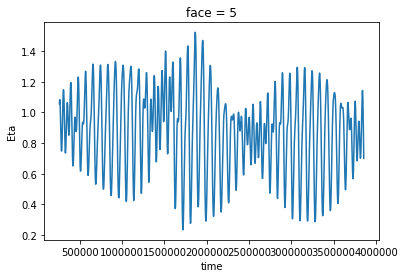

In [8]:
#%time ds['Eta'].isel(face=1, i=slice(0,100), j=slice(0,100)).mean(dim=['i','j']).plot()
%time ds['Eta'].isel(face=5, i=slice(3000,3200), j=slice(100,300), time=slice(0,1000)).mean(dim=['i','j']).plot()

# SST
________


In [9]:
# read SST outputs using xrray and xmitgcm
data_dir = '/home/datawork-lops-osi/data/mit4320/SST/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('SST', data_dir, delta_t=25.)

ds = get_compressed_data('SST', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['SST'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SST'].isel(face=1).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 6747)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

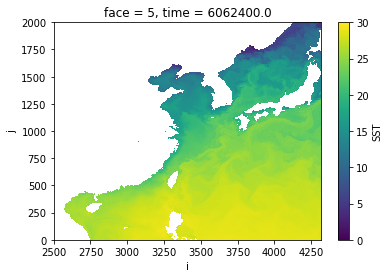

In [10]:
ds['SST'].isel(face=5, time=100, i=slice(2500,4320), j=slice(0,2000)).plot(vmin=0, vmax=30)

In [ ]:
%time ds['SST'].isel(face=5, i=slice(3500,4000), j=slice(250,1000), time=slice(0,3000)).mean(dim=['i','j']).plot()

# SSU 

______

In [6]:
data_dir = '/home/datawork-lops-osi/data/mit4320/SSU/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('SSU', data_dir, delta_t=25.)

ds = get_compressed_data('SSU', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['SSU'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SSU'].isel(face=1).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 6741)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

In [7]:
ds['SSU'].isel(face=0, time=0).plot()

ValueError: NumPy boolean array indexing assignment cannot assign 140494612 input values to the 140637966 output values where the mask is true

In [13]:
%time m1 = ds['SSU'].isel(face=1).mean(['time']).persist()

CPU times: user 2.8 s, sys: 28 ms, total: 2.82 s
Wall time: 2.83 s


ValueError: NumPy boolean array indexing assignment cannot assign 140494612 input values to the 140637966 output values where the mask is true

---

# basic statistics

In [12]:
%time m1 = ds['Eta'].isel(face=1).mean(['time']).persist()

CPU times: user 1.76 s, sys: 4 ms, total: 1.76 s
Wall time: 1.77 s


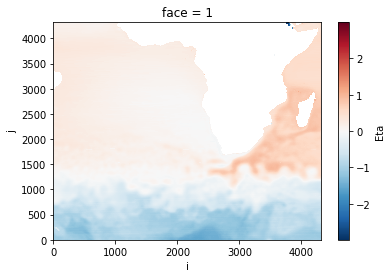

In [13]:
m1.plot()

---

# info, shutdown

In [8]:
client.restart()

Client Scheduler: tcp://10.148.0.148:8786 Dashboard: http://10.148.0.148:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB
